This code is the dummy code that:

Input: 
- random "fidelity" F from 0 to 1
- property P that was calculated from F

Output:
- Macchine learned `model` that given P output a predicted F

In [16]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from qutip import *
import matplotlib.pyplot as plt
from visualisation_tools import *
from model_generator import *
from qsq_protocol import *

plt.rcParams.update({
    "figure.figsize": (10, 6),
    "text.usetex": False, # Remove this line if your code doesn't run/ take too long
    "font.family": 'Times New Roman',
    "figure.dpi": 100,
    "font.size": 14
})

In [2]:
experiment_prob_failing(rho_ideal,S_gate,M_ideal)
average_fidelity(rho_ideal,S_gate,M_ideal)

np.float64(1.0)

In [3]:
rho_exp = rand_dm(2)
M_exp = ket2dm(rand_ket(2))
gate_exp = rand_unitary(2)
experiment_prob_failing(rho_exp,gate_exp,M_exp)
average_fidelity(rho_exp,gate_exp,M_exp)

np.float64(0.496714)

In [4]:
def depolarize(rho, p):
    """Apply depolarizing noise with probability p to state rho."""
    dim = rho.shape[0]
    return (1 - p) * rho + p * qeye(dim) / dim

In [5]:
import itertools
import random

# Number of units and iterations

N_uniform = 20
N_random = 2000
N_perturbed = 30

# Example: Generate a grid of 20 theta steps and 40 phi steps 
theta_steps = 5 # Number of steps for theta (polar angle) 
phi_steps = 5 # Number of steps for phi (azimuthal angle) 
density_matrices = generate_density_matrices(theta_steps, phi_steps) 
# Check that there's no repetitions 
uniform_dm = [] 
seen_matrices = set() 
for rho in density_matrices: 
    matrix_repr = str(rho) # Convert Qobj to its string representation 
    if matrix_repr not in seen_matrices: 
        uniform_dm.append(rho)
        seen_matrices.add(matrix_repr)
# Generate uniform unitary matrices and data
uniform_U = generate_random_unitaries(N_uniform)
uniform_data = [(dm1, unitary, dm2) for dm1, unitary, dm2 in itertools.product(uniform_dm, uniform_U, uniform_dm)]


# Generate random data
random_data = []
for i in range(N_random):
    rho_exp = rand_dm(2)
    M_exp = ket2dm(rand_ket(2))
    gate_exp = rand_unitary(2)
    random_data.append([rho_exp,M_exp,gate_exp])

# Generate perturbed unitary matrices and data
perturbed_dm = generate_perturbed_rho(rho_ideal,np.linspace(0.01,0.1,N_perturbed))
perturbed_U = generate_perturbed_unitary(S_gate,N_perturbed)

perturbed_data = [(dm1, unitary, dm2) for dm1, unitary, dm2 in itertools.product(perturbed_dm, perturbed_U, perturbed_dm)]


# Combine all data into one list
full_data = perturbed_data

# Shuffle the combined data
def split_data(data, test_size=0.2):
    """
    Split the data into training and testing sets.

    Args:
        data: List of data to split.
        test_size: Fraction of the data to use for testing (default 0.2 for 20% test data).

    Returns:
        train_data: Data for training.
        test_data: Data for testing.
    """
    # Shuffle the data to ensure randomness
    data = random.shuffle(data)

    # Calculate the split index
    split_index = int(len(data) * (1 - test_size))

    # Split the data
    training_data = data[:split_index]
    test_data = data[split_index:]

    return training_data, test_data

# training_data, test_data = split_data(full_data)
training_data = full_data

# Print the lengths of all datasets
print(f"Length of uniform_data: {len(uniform_data)}")
print(f"Length of random_data: {len(random_data)}")
print(f"Length of perturbed_data: {len(perturbed_data)}")
print(f"Length of training_data: {len(training_data)}")


Length of uniform_data: 5780
Length of random_data: 2000
Length of perturbed_data: 27000
Length of training_data: 27000


In [6]:
F = []
P = []
for datum in training_data:
    rho_exp = datum[0]
    gate_exp = datum[1]
    M_exp = datum[2]
    F.append(average_fidelity(rho_exp,gate_exp,M_exp))
    P.append(experiment_prob_failing(rho_exp,gate_exp,M_exp))

d:\Program Files\python\Lib\site-packages\qutip\core\data\expm.py:136: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


Text(0.5, 1.0, 'Distribution of Input data')

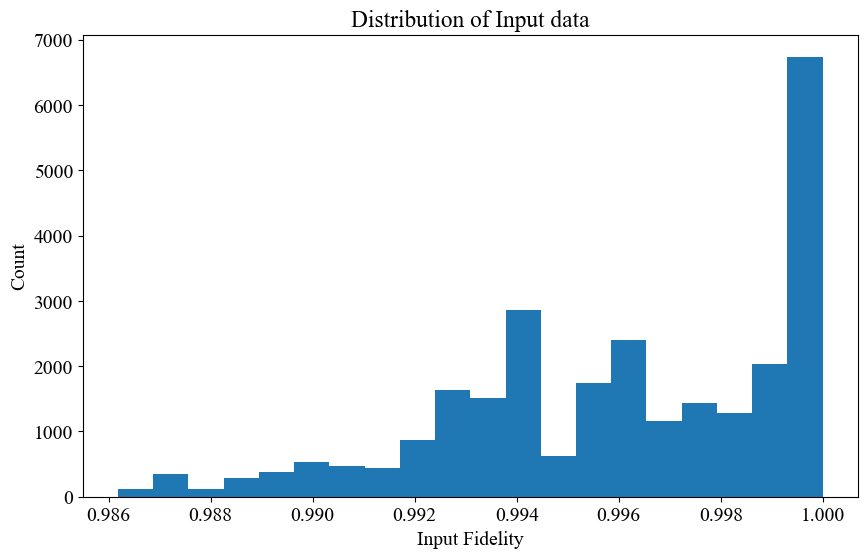

In [26]:
plt.hist(F,bins=20)
plt.xlabel('Input Fidelity')
plt.ylabel('Count')
plt.title('Distribution of Input data')

In [8]:
# Convert to PyTorch tensors
X = torch.tensor(P, dtype=torch.float32)   # inputs: 3 probabilities
y = torch.tensor(F, dtype=torch.float32).unsqueeze(1)  # output: fidelity

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# -----------------------------
# Simple MLP model
# -----------------------------
# model = nn.Sequential(
#     nn.Linear(3, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1)
# )

model = nn.Sequential(
    nn.Linear(3, 64),
    nn.ReLU(),
    # nn.Dropout(0.3),
    nn.Linear(64, 64),
    nn.ReLU(),
    # nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    # nn.Dropout(0.3),
    nn.Linear(32, 1)
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# Training loop
# -----------------------------
epochs = 50
for epoch in range(epochs):
    for xb, yb in dataloader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 10, Loss: 0.000000
Epoch 20, Loss: 0.000001
Epoch 30, Loss: 0.000002
Epoch 40, Loss: 0.000001
Epoch 50, Loss: 0.000000


In [9]:
perturbed_dm = generate_perturbed_rho(rho_ideal,np.linspace(0.01,0.1,10))
perturbed_U = generate_perturbed_unitary(S_gate,10)
test_data = [(dm1, unitary, dm2) for dm1, unitary, dm2 in itertools.product(perturbed_dm, perturbed_U, perturbed_dm)]
random.shuffle(test_data)

In [10]:
# -----------------------------
# Test prediction
# -----------------------------
true_fidelities = []
pred_fidelities = []

# Loop over multiple test cases
for datum in test_data:
    rho_exp = datum[0]
    gate_exp = datum[1]
    M_exp = datum[2]
    # Get the test probability and fidelity
    test_P = torch.tensor(experiment_prob_failing(rho_exp, gate_exp, M_exp)).unsqueeze(0)  # Batch dimension (1 sample)
    test_F = average_fidelity(rho_exp, gate_exp, M_exp)

    # Get the model prediction
    pred_F = model(test_P).detach().numpy().flatten()

    # Store the results
    true_fidelities.append(test_F)
    pred_fidelities.append(pred_F)

# Convert lists to numpy arrays for plotting
true_fidelities = np.array(true_fidelities)
pred_fidelities = np.array(pred_fidelities)

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_20560\295726723.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([min(true_fidelities), max(true_fidelities)], [min(true_fidelities), max(true_fidelities)], 'r--', color='C1', label='Ideal 1:1 Line')


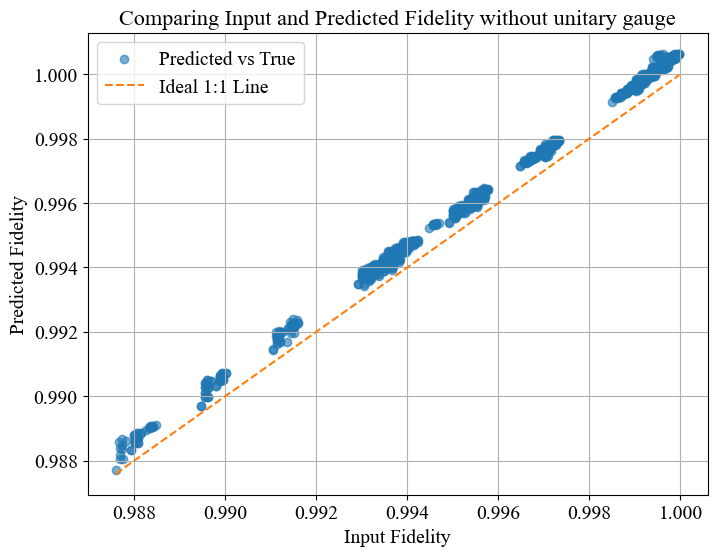

In [21]:
# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(8, 6))

# Scatter plot of true vs predicted fidelities
plt.scatter(true_fidelities, pred_fidelities, label='Predicted vs True', alpha=0.6)

# Plot ideal 1:1 line (perfect prediction)
plt.plot([min(true_fidelities), max(true_fidelities)], [min(true_fidelities), max(true_fidelities)], 'r--', color='C1', label='Ideal 1:1 Line')

# Labels and title
plt.xlabel("Input Fidelity", fontsize=14)
plt.ylabel("Predicted Fidelity", fontsize=14)
plt.title("Comparing Input and Predicted Fidelity without unitary gauge", fontsize=16)

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()